In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "auto_mpg_data.tsv"
auto_mpg_names = "names_auto_mpg.txt"

# Problem Set 5

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown. You will submit only this notebook named: [jhed_id].ipynb back to Blackboard from whence you downloaded it. Do not return the data to me.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**

## Introduction

Labs 9 and 10 were all about linear models, specifically linear and logistic regression. We learned how to build and interpret multivariate models by using domain knowledge, comparing the predicted and actual values of the coefficients and the credible intervals, and looking at residuals. We also applied transformations to make the models perform better and increase interpretability.

Using the techniques covered during Modules 9 and 10 (lectures, labs, course notes), **build, describe, and use** a linear regression model that estimates the target variable `mpg` for the accompanying auto data set. You may use other techniques you know but you must at least use the techniques described in class and call out and describe anything "extra" that you do and why.

Do **not** use any feature selection techniques or anything other than linear regression. Follow the method described in class.

The instructions say build, **describe, and use**. You must describe all aspects of your final model (all the parameters and metrics) and use it to predict one value as described in the course notes.

## Hints From BlackBoard

I am adding a few days to the Problem Set 5 deadline.

1. The final, complete assignment is due Sunday, August 16. Yes, it still says August 11. Keep reading.
2. You MUST still submit a milestone by Tuesday, August 11. This milestone will consist of your ETL and EDA for the problem. Failure to submit will result in -1 to your final grade. I will change the deadline for the assignment on August 12.



Pointers

1. You may need to acquire domain knowledge. That domain knowledge should be described and referenced in the notebook.
1. For ETL and EDA, follow the Lab 5 Solution closely. Don't stray from the plot. The entire point of the framework for EDA is to be methodical and scientific.
1. You need to build a linear regression model. This assignment covers modules 9, 10, 11. Use the process outlined in the Lectures and  Fundamentals. Do not use anything other than linear regression.
1. Make sure you actually do 1.5...use the model. You built a model. Make a prediction with it. Calculate the error bounds. This is in the entire point of building a model. There's an example in Fundamentals.

Additional

Please make sure you submit one single notebook. Yes, it's going to get big. Add internal links and a table of contents. However, if you like, you can have your "library" code in a single external file called (your JHED id).py. You can then import it. But only "library code".



## 1.1 - ETL


To begin the ETL process, let's start with taking a look at the columns. The file `names_auto_mpg.txt` contains this information at the bottom

> 7. Attribute Information:
>
>    1. mpg:           continuous
>    2. cylinders:     multi-valued discrete
>    3. displacement:  continuous
>    4. horsepower:    continuous
>    5. weight:        continuous
>    6. acceleration:  continuous
>    7. model year:    multi-valued discrete
>    8. origin:        multi-valued discrete
>    9. car name:      string (unique for each instance)
>
>8. Missing Attribute Values:  horsepower has 6 missing values

From this we can create a list of the names, and load in our data. From inspecting the data file, I also notice that there are some missing values denoted by '?'; we'll instruct pandas to read them as `na_values`

In [3]:
names = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"]

mpg = pd.read_csv("auto_mpg_data.tsv", delim_whitespace = True, names = names, na_values="?")

Now let's take a deeper look into our `mpg` data to get an idea of the data types pandas is using, and if we want to change any of them based on the description given above

In [4]:
mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


Comparing this table to what `names_auto_mpg.txt` told us, these data types look pretty good. We can also see those 6 missing values in `horsepower` that it warned us of. 

In [5]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


What we are looking for here is anything that might be off or strange about the way the data looks. For example, if weight had three decimal places, even though the values are in the thousands. However, there do not seem to be any issues of that sort. From a first glance, the columns `mpg`, `displacement`, `horsepower`, and `weight` are all floating point numbers that seem to end in .0. It might be possible to convert them to integers if they never have any more decimal values other than .0

## 1.2 - EDA


### 1.2.1 MPG

MPG (miles per gallon) is a measure of efficiency of a car. Since this data is taken from the 70s and 80s, we can probably expect the average `mpg` to be lower than today's. I would probably expect this to be something like a lognormal curve; most cars clump together a little lower down, and a few have higher mpgs. 

Let's take a look at summary statistics to get a sense of the range, and maybe pick out anomalies (0 mpg, 300 mpg)

In [6]:
mpg.mpg.describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

Nothing shocking here. Let's move on to a histogram

In [7]:
def plot_hist_w_labels(df: pd.DataFrame, col: str):
    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)
    axes.hist(df[col], color="darkslategray")
    axes.set_title(f"Distribution of {col}")
    axes.set_xlabel(col)
    axes.set_ylabel("Frequency")

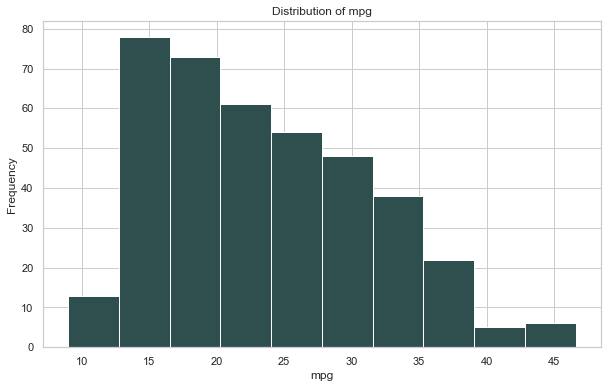

In [8]:
plot_hist_w_labels(mpg, "mpg")

A few things to note, there are few cars with an mpg less than 15, but a majority sit just above 15. From there, frequency steadily declines until we reach 40, at which point there are fewer than we might expect if we follow the pattern. This is not quite the lognormal curve I predicted, but it does have a sharp growth to a maximum, and a "tail" to the right.

### 1.2.2 Cylinders

`cylinders` refers to the number of cylinders in a car's engine. Generally, the more cylinders a car has, the more gas it can combust at once, the more horsepower it has. More cylinders also usually corresponds with lower MPG. There are almsot always an even number of cylinders to match the vibrations; as one goes up, another goes down, or the whole engine might shake itself apart. 
![Car Engine](img/car_engine.jpg)

Note that in some notable cases, they do not need an even number due to configuration. Take, for example, this airplane engine which places cylinders in a circle around the drive shaft.
![Plane Engine](img/airplane_engine.jpg)

I would expect this go between maybe 2 and 12 cylinders; 12 being something like the number of cylinders in a possible supercar

In [9]:
mpg.cylinders.describe()

count    398.000000
mean       5.454774
std        1.701004
min        3.000000
25%        4.000000
50%        4.000000
75%        8.000000
max        8.000000
Name: cylinders, dtype: float64

The minimum is 3 cylinders, which is slightly unexpected. The max is 8, already plenty for a supercar. Let's see how many of each there are:

In [10]:
mpg.cylinders.value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

Most are either 4, 8, or 6. A very few have 3 or 5 cylinders. 

Because there are distinct numbers of cylinders, let's use a bar chart instead of a histogram.

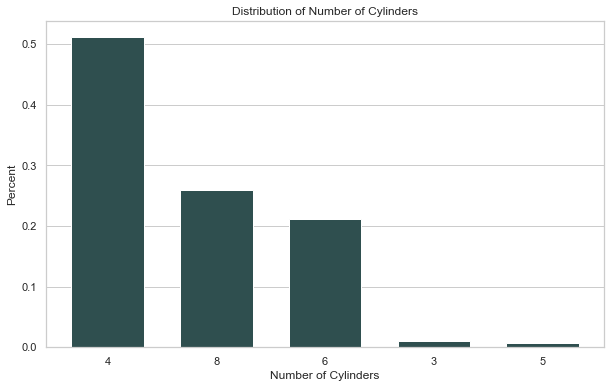

In [11]:
data = mpg.cylinders.value_counts(normalize=True)
x = range( len( data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks([0, 1, 2, 3, 4])
axes.set_xticklabels(data.axes[0])
axes.set_title("Distribution of Number of Cylinders")
axes.set_xlabel("Number of Cylinders")
axes.set_ylabel("Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

Over half the cars have 4 cylinder engines, around 20-25% have 8 or 6 cylinders, and a very few percent have 3 or 5.

### 1.2.3 Displacement

`displacement` refers generally to the total volume displaced by the pistons. The larger the displacement, the more air is combusting with your gas (and you've probably injected more gas as well), which means more powerful combustion, which means higher horsepower (usually), and lower efficiency (usually). It is possible to have a high displacement engine that is efficient when run at low rpms. Often, displacement is measured in cc (cubic centimeters), but we don't know for sure that that is the unit used in this dataset. 

I would expect that the distribution of displacement looks like a flipped version of `mpg`'s, as the lower displacement cars are probably more efficient.

In [12]:
mpg.displacement.describe()

count    398.000000
mean     193.425879
std      104.269838
min       68.000000
25%      104.250000
50%      148.500000
75%      262.000000
max      455.000000
Name: displacement, dtype: float64

No surprises here, a minimum of 68, and a maximum of 455. I would probably assume that the units are in cc. 

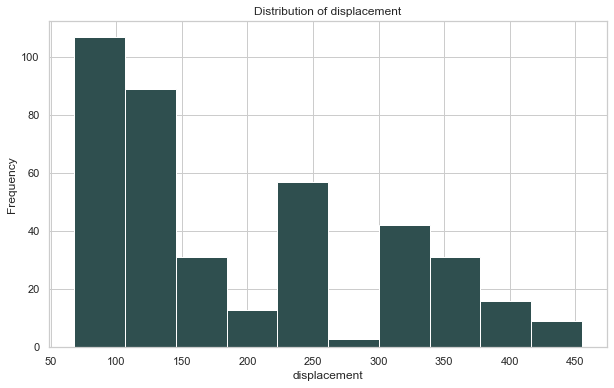

In [13]:
plot_hist_w_labels(mpg, "displacement")

If displacement were driven only by engineering "goodness", fun, and efficiency, I would expect a continuous-looking distribution. This is clearly not a continuous distribution. The overall trend is generally decreasing, but with large gaps where we would expect to see more cars with a given displacement. One possible reason for this is [governmental regulations](https://en.wikipedia.org/wiki/Engine_displacement#Governmental_regulations). For example, at the time these cars were created, there might have been a larger tax on cars with displacements above 250. Hence, many cars go right up to the limit of 250, very few go just above it. And at around 300, this consideration probably goes away as cars get more into the land of expensive sports cars and muscle cars, where people are more willing to pay for more power.

### 1.2.4 Horsepower

Horsepower is a measure of energy produced per second (1 hp $\approx$ 745.7 W). I would haved expected this to be something like a lognormal curve. Howerver, given the distribution of displacement that we have seen, I would hesitate to expect a continuous-looking distribution. 

In [14]:
mpg.horsepower.describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

There is a minimum of 75hp and a max of 230. These numbers are pretty reasonable. We should also remember that six of the values are missing, and marked as `NaN` in our dataframe. 

/Users/natemcintosh/miniconda3/envs/en685648/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/natemcintosh/miniconda3/envs/en685648/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


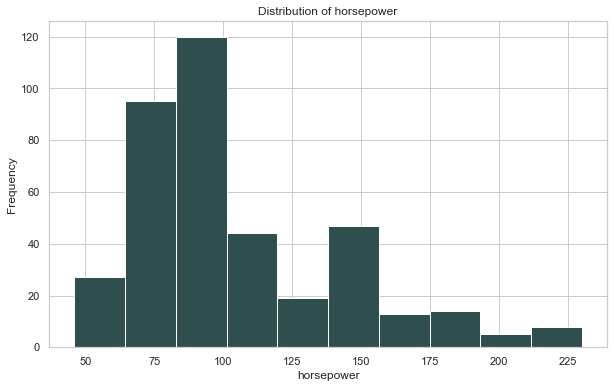

In [15]:
plot_hist_w_labels(mpg, "horsepower")

There is something of a lognormal curve here, but there is a very clear jump around 150 hp. Was 150hp a 'magic number' in the 70s and 80s, where cars with that much power sold better? 

---
## 1.3 - Build the model

---
## 1.4 - Describe the model

---
## 1.5 - Use the model



---

**CHECK LIST**

Before you submit this assignent, go back and review the directions to ensure that you have followed each instruction.



*   Have you completed every section and answered every question asked?
*   For every question, have you described your approach and explained your results?
*   Have you checked for spelling and grammar errors?
*   Are your code blocks free of any errors?
*   Have you *SAVED* your notebook?

